### 1. Load Raw Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MotionData as m
%matplotlib inline

#use the MotionData.py class to load motion data and clean data
motionLoader = m.MotionData('data')
motion = motionLoader.motion
valid_questionnaire = motionLoader.qs

#Join valid users from questionnaire with motion dataframe...effectively removing users from the motion dataframe that do not have valid questionnaire data
motion = pd.merge(valid_questionnaire[['user']],motion,on='user',how='left')

### 2. Motion File Processing:

##### 2.1 Users that have uploaded less than 40 hours of movement data (40 hours when phone was not stationary) will be removed
##### f2-28 features will be NAN for hours where NO movement occured (details <a href="featureDescriptions.md">here</a>). We use f2 the count hours of non-NAN values

In [2]:
#Count number of f2 features for each user....using f2 as we want to count number of hours where there was activity. If f2 is NAN then there was no activity
NUM_ACTIVE_DAYS_NEEDED = 5
entryCounts = motion.groupby(by='user').count()[['f2']]
#select users with at least 40 hours of non-stationary motion data
validmotion_Users= entryCounts[entryCounts['f2'] > 8 * NUM_ACTIVE_DAYS_NEEDED].reset_index()
print(f"Motion file has {validmotion_Users.shape[0]} users with at least {8 * NUM_ACTIVE_DAYS_NEEDED} hours of active motion data")


Motion file has 307 users with at least 40 hours of active motion data


#### 2.2 Left join valid user with full motion file...in effect this will remove non valid users from the motion dataframe


In [3]:
validmotion = pd.merge(validmotion_Users['user'],motion,on='user',how='left')

#### 2.3 Group motion file by user and by day....allowing us to compute summary features of motion per day for each user

In [4]:
validmotion['day'] = validmotion['datetime'].dt.date

dailyMotionAggs = validmotion.drop('datetime',axis=1).groupby(by=['user','day']).agg(['mean','min','max','std','median'])

# get rid of multi level column names and change to single flat column names which combines level0 and level1 naming
flatCols = dailyMotionAggs.columns.get_level_values(0) + '_' +  dailyMotionAggs.columns.get_level_values(1)
dailyMotionAggs.columns = flatCols

#### 2.4 After computing summary features for each individual day, combine all daily features into an overall feature to summarise motion for each user

In [5]:
#summaryMotionAggs  = dailyMotionAggs.reset_index().groupby(by="user").mean()
summaryMotionAggs  = dailyMotionAggs.groupby(by="user").agg(['mean','std','min','max','median'])
flatColsDays = summaryMotionAggs.columns.get_level_values(0) + '_' +  summaryMotionAggs.columns.get_level_values(1)
summaryMotionAggs.columns = flatColsDays
summaryMotionQS = pd.merge(summaryMotionAggs.reset_index(),valid_questionnaire,on='user',how='left')

## 3 Motion File Exploritory Analysis
#### 3.1 Investigate Correlations between Result1, Result2 and different motion features


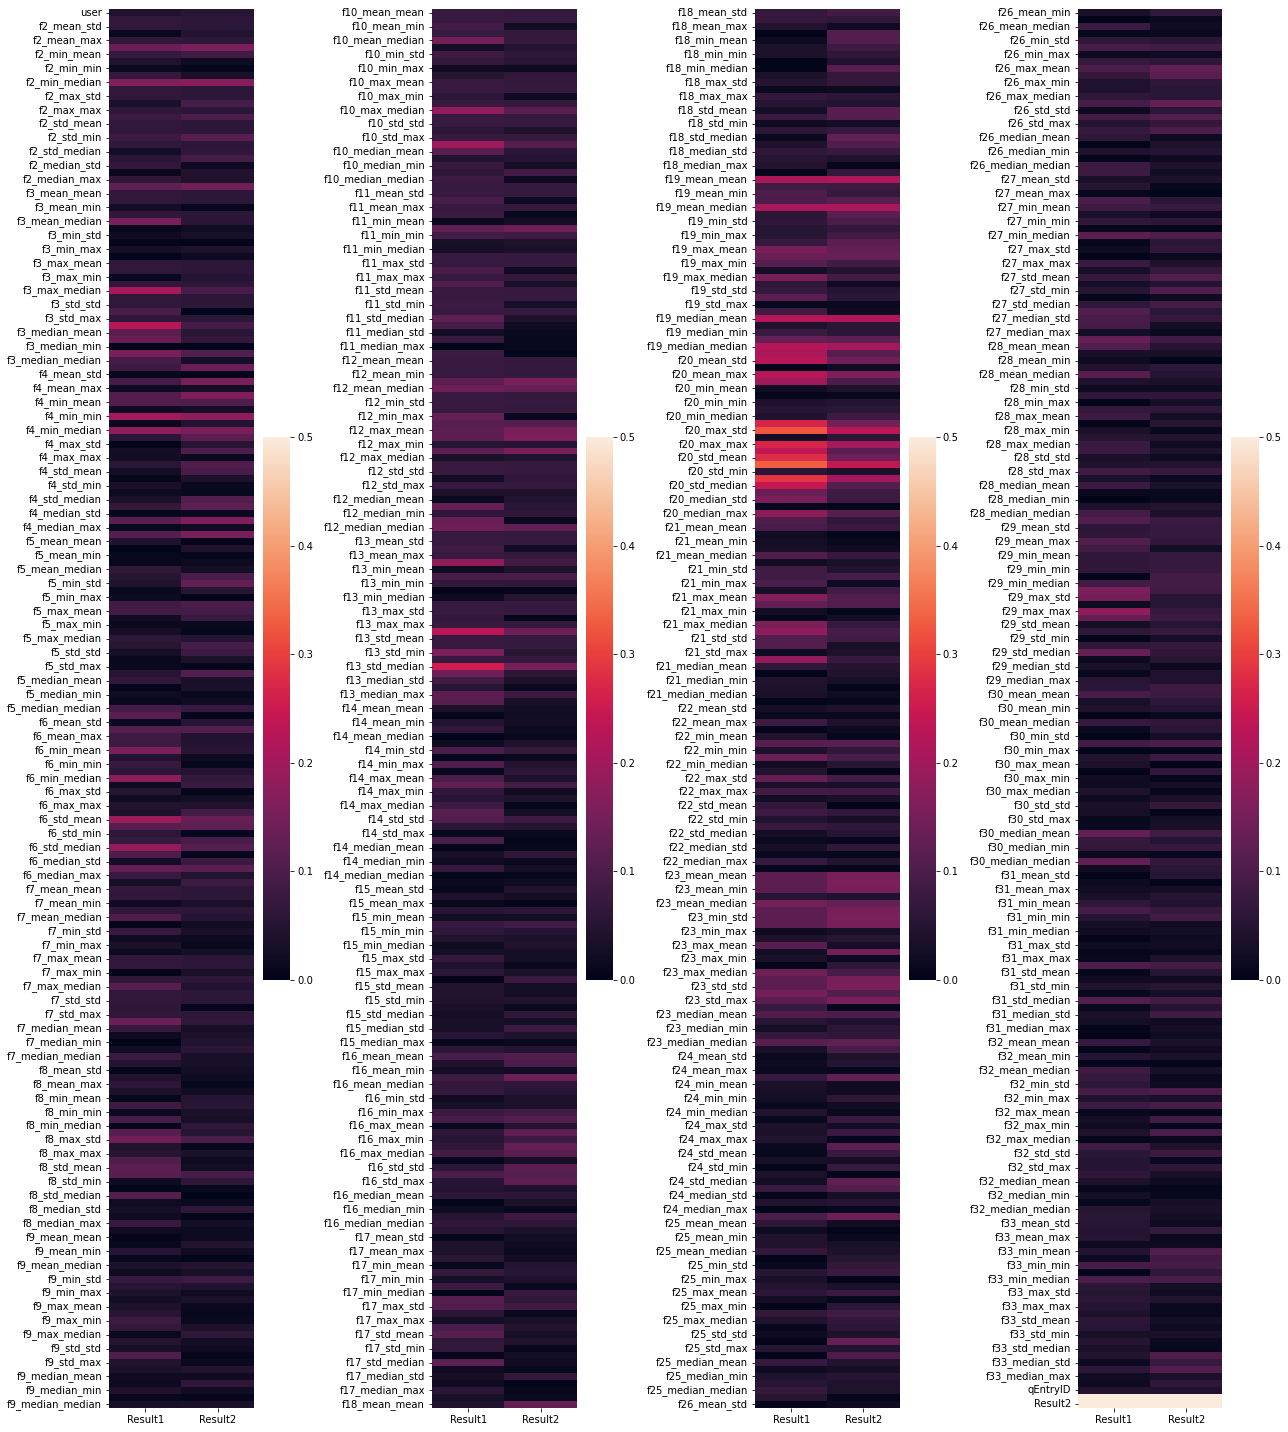

In [6]:
#calculate correlation matrix and store correlations between features and the two SF26 measures (Result1 and Result2)
correlation = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1','Result2']]

#display correlations in number of seperate heatmaps for just Result1 and Result2 to make is easier to view
NUM_SUBPLOTS = 4
fig, axes = plt.subplots(1, NUM_SUBPLOTS, figsize=(18,20))

#for each subplot, plot a segment of the correlation matrix
for i in range(0,NUM_SUBPLOTS):
    sns.heatmap(ax=axes[i],data=correlation.iloc[int(correlation.shape[0]/NUM_SUBPLOTS)*i:int(correlation.shape[0]/NUM_SUBPLOTS)*(i+1),:].abs(),vmin=0, vmax=0.5)

fig.tight_layout()
plt.show()

### Top 10 Correlations between Result1 (Physical Component Score) and different motion features

In [7]:
topCorrelationsResult1 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1']].sort_values('Result1',ascending=False).head(10)
topCorrelationsResult1.T

,Result1,Result2,f20_std_std,f20_max_std,f20_std_max,f20_std_mean,f20_max_max,f20_max_mean,f13_std_median,f20_std_median
Result1,1.0,0.695178,0.330391,0.321754,0.290286,0.27917,0.26927,0.26808,0.255613,0.241638


### Top 10 Correlations between Result2 (Mental Component Score) and different motion features

In [8]:
topCorrelationsResult2 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result2']].sort_values('Result2',ascending=False).head(10)
topCorrelationsResult2.T

,Result2,Result1,f20_std_std,Age,f20_max_std,f19_median_mean,f19_mean_mean,f19_mean_median,f20_max_max,f20_std_max
Result2,1.0,0.695178,0.244054,0.242317,0.231653,0.217859,0.215533,0.20952,0.206479,0.203762


## Visual analysis of correleation between Result1/Result2 and top 10 correlating features

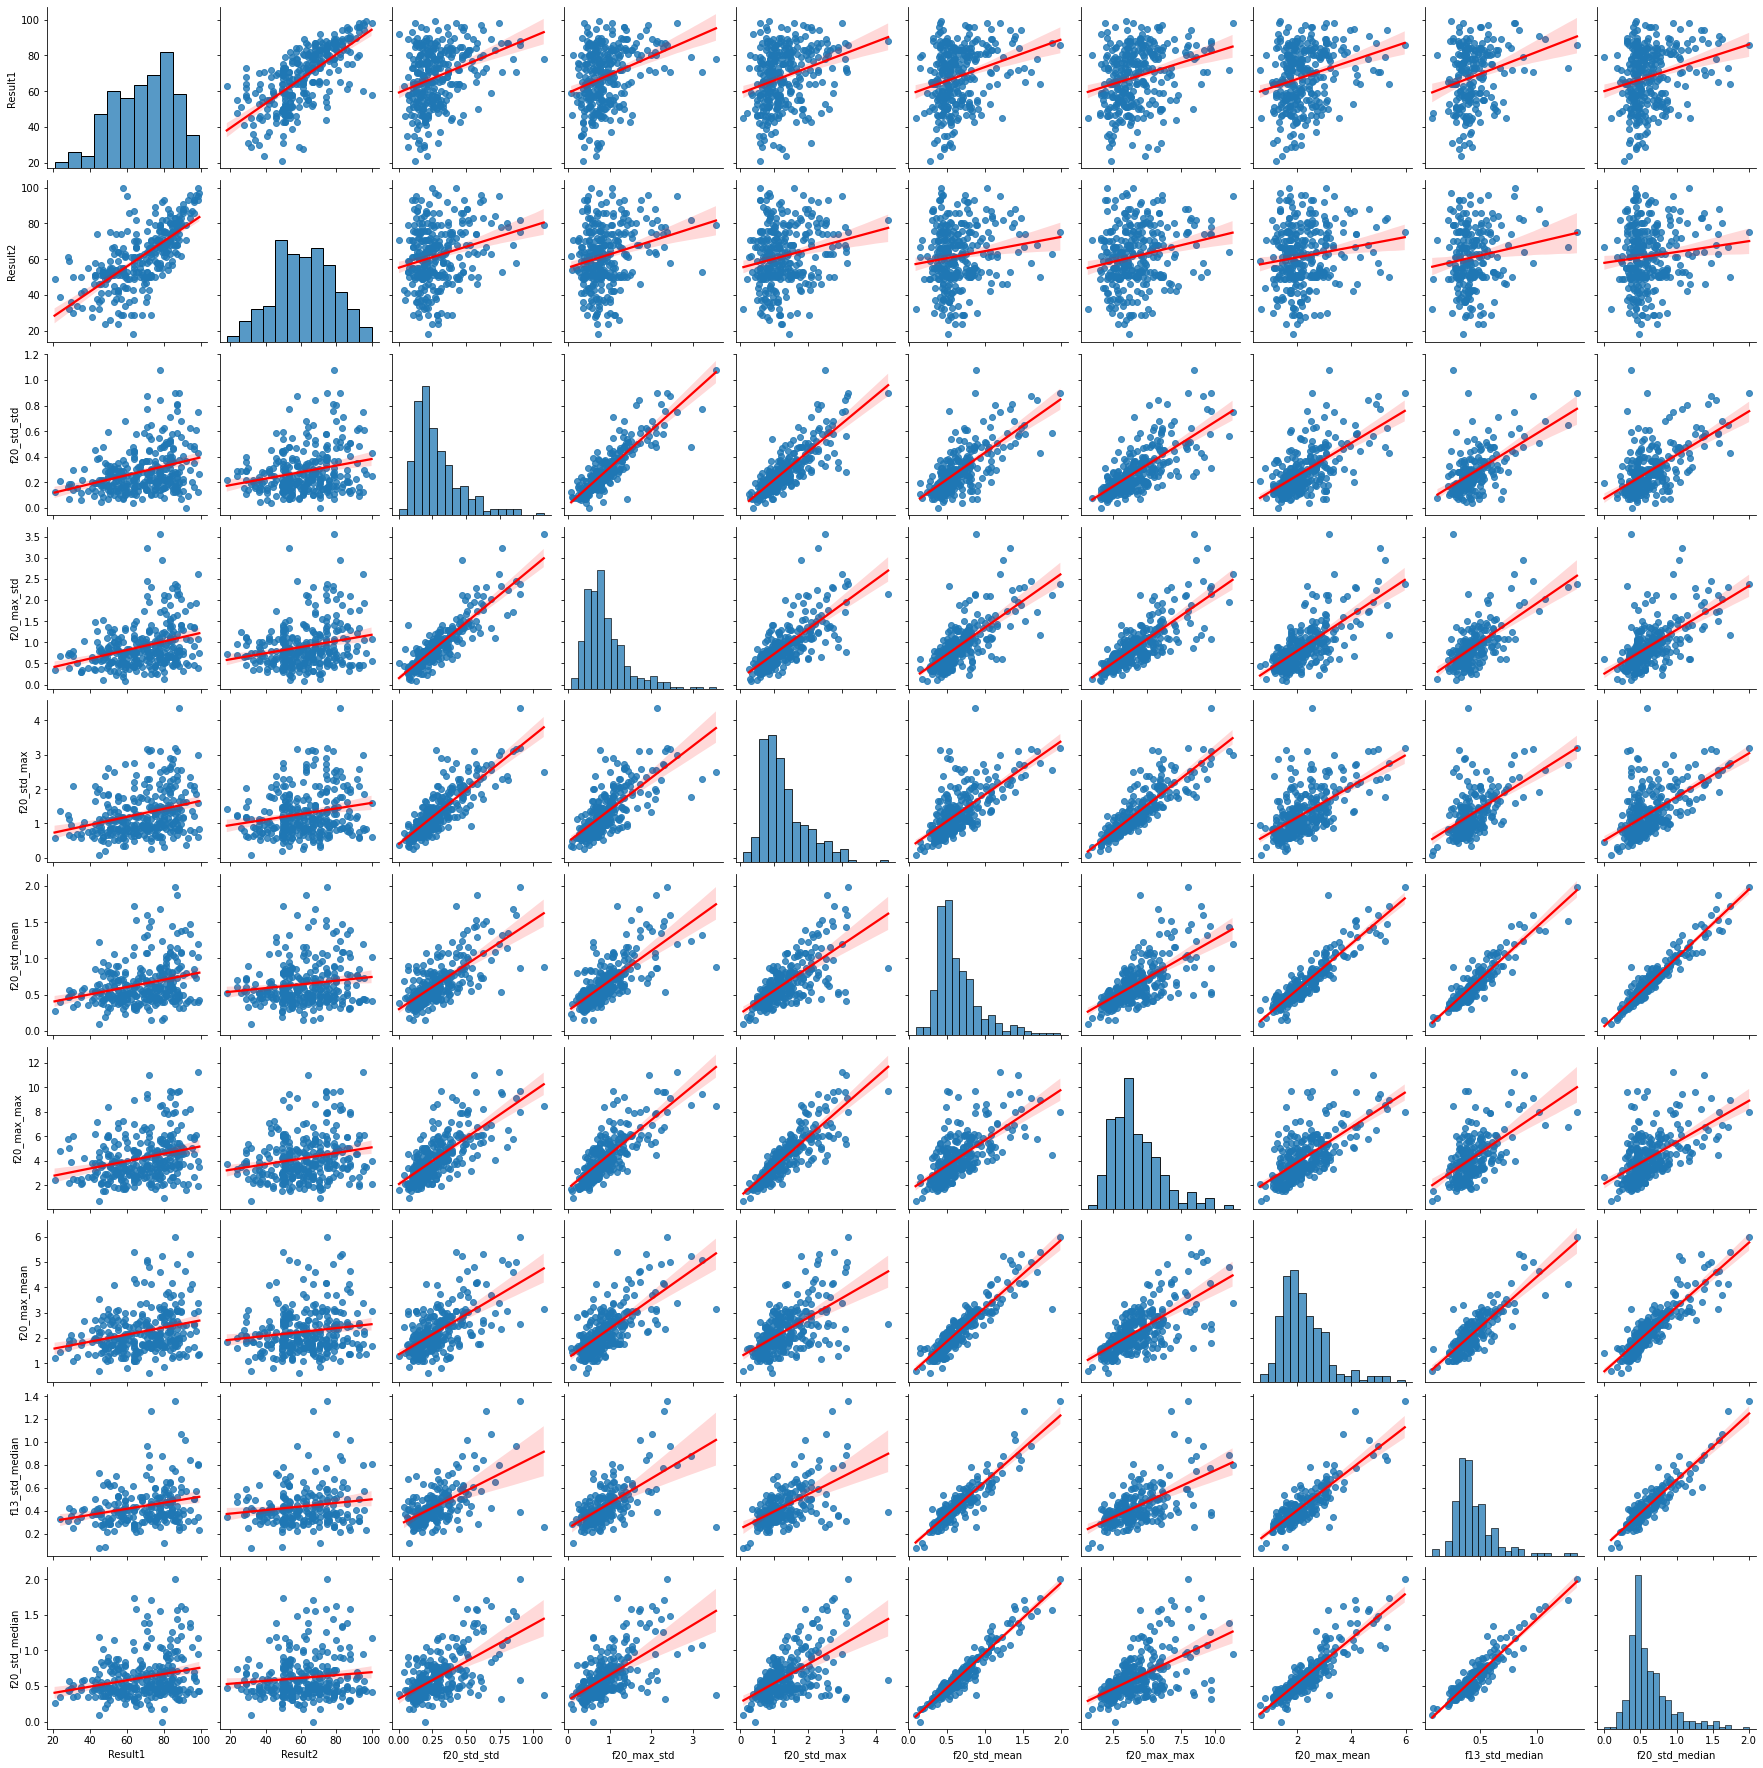

In [10]:
sns.pairplot(summaryMotionQS[topCorrelationsResult1.index.values.tolist()],kind="reg", plot_kws={'line_kws':{'color':'red'}})

## 4. Basic Machine Learning Modelling

In [14]:
#load require scikit-learn libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import scipy as sp
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [10]:
#built feature vector matrix X
X = summaryMotionQS.iloc[:,2:summaryMotionQS.shape[1]-45]
#build label matrix y...y has 2 columns, one for Result1 labels and one for Result2 labels. Models will be training independently on both of these
y = summaryMotionQS[['Result1','Result2']]

In [11]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
#create Result1 and Result2 specific y train and test vectors
y_train_Result1 = y_train['Result1']
y_train_Result2 = y_train['Result2']
y_test_Result1 = y_test['Result1']
y_test_Result2 = y_test['Result2']

In [88]:
#Random Forest Initalize
model1 = make_pipeline(SimpleImputer(strategy='median'),StandardScaler(),SelectKBest(mutual_info_regression, k=20),RandomForestRegressor(n_estimators=50,random_state = 42))

param_grid = [{'selectkbest__k': [10,50,100,200],
    'randomforestregressor__bootstrap': [True, False],
 'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'randomforestregressor__max_features': [1, 'sqrt'],
 'randomforestregressor__min_samples_leaf': [1, 2, 4],
 'randomforestregressor__min_samples_split': [2, 5, 10],
 'randomforestregressor__n_estimators': [100, 200, 400, 600, 800, 1000, 1500]}]

In [22]:
#xgboost initialize
model1 = make_pipeline(SimpleImputer(strategy='median'),StandardScaler(),SelectKBest(mutual_info_regression, k=20),XGBRegressor(n_estimators=50,random_state = 42))

param_grid = {'selectkbest__k': [10,50,100,200],
              'xgbregressor__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'xgbregressor__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'xgbregressor__max_depth': [5,6,7,8,9,10,11,12,13,14],
              'xgbregressor__n_estimators': [50,100,150,200,500,750,1000],
              'xgbregressor__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'xgbregressor__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [12]:
#LightGBM Initialise
model1 = make_pipeline(SimpleImputer(strategy='median'),StandardScaler(),SelectKBest(mutual_info_regression, k=20),LGBMRegressor(n_estimators=50,random_state = 42))

param_grid =[{'selectkbest__k': [50,100,200,250,300],
             'lgbmregressor__num_leaves': sp_randint(3, 50), 
             'lgbmregressor__min_child_samples': sp_randint(100, 500), 
             'lgbmregressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgbmregressor__subsample': sp_uniform(loc=0.2, scale=0.8), 
             'lgbmregressor__colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'lgbmregressor__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'lgbmregressor__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'lgbmregressor__n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]}]

In [23]:
grid1 = RandomizedSearchCV(model1,param_grid,scoring='neg_root_mean_squared_error',n_iter=200,cv=5,verbose=1,n_jobs=-1)
grid1.fit(X_train,y_train_Result1)

print(grid1.best_params_)
print(grid1.best_score_)

test_pred = grid1.best_estimator_.predict(X_test)

evaluate(grid1.best_estimator_,X_test,y_test_Result1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'xgbregressor__reg_lambda': 51.2, 'xgbregressor__reg_alpha': 12.8, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.300000012, 'xgbregressor__gamma': 102.4, 'selectkbest__k': 200}
-16.12384210620404
Model Performance
Average Error: 18.4173
Accuracy = 71.05%.


71.04927815505775

{'xgbregressor__reg_lambda': 51.2, 'xgbregressor__reg_alpha': 12.8, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.300000012, 'xgbregressor__gamma': 102.4, 'selectkbest__k': 200}
-16.12384210620404
22.677661463532395
Model Performance
Average Error: 18.4173
Accuracy = 71.05%.


/home/ubuntu/miniconda3/envs/healthu/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Result1'>

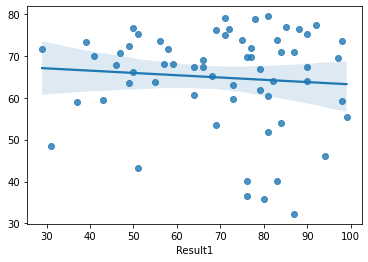

In [25]:
#### xgboost
print(grid1.best_params_)
print(grid1.best_score_)
print(mean_squared_error(y_test_Result1,test_pred)**0.5)
evaluate(grid1.best_estimator_,X_test,y_test_Result1)
sns.regplot(y_test_Result1,test_pred)

{'lgbmregressor__colsample_bytree': 0.4011884348946221, 'lgbmregressor__min_child_samples': 254, 'lgbmregressor__min_child_weight': 1, 'lgbmregressor__n_estimators': 400, 'lgbmregressor__num_leaves': 28, 'lgbmregressor__reg_alpha': 2, 'lgbmregressor__reg_lambda': 100, 'lgbmregressor__subsample': 0.882338539449451, 'selectkbest__k': 100}
-16.033918411225084
17.986599869121353
Model Performance
Average Error: 15.3848
Accuracy = 74.42%.


/home/ubuntu/miniconda3/envs/healthu/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Result1'>

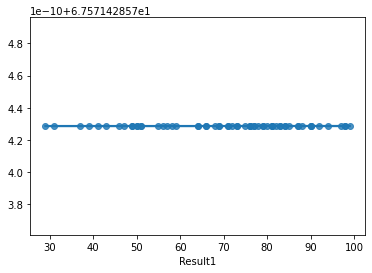

In [21]:
#### lightgbm
print(grid1.best_params_)
print(grid1.best_score_)
print(mean_squared_error(y_test_Result1,test_pred)**0.5)
evaluate(grid1.best_estimator_,X_test,y_test_Result1)
sns.regplot(y_test_Result1,test_pred)

In [62]:
#### XGB

print(mean_squared_error(y_test_Result1,test_pred)**0.5)
evaluate(grid1.best_estimator_,X_test,y_test_Result1)

15.309326793218341
Model Performance
Average Error: 12.1570
Accuracy = 81.57%.


81.57021150387735

In [19]:
test_pred

array([67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857, 67.57142857, 67.57142857, 67.57142857,
       67.57142857, 67.57142857])

In [17]:
sp.stats.pearsonr(y_test_Result1,test_pred)

/home/ubuntu/miniconda3/envs/healthu/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)

/home/ubuntu/miniconda3/envs/healthu/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Result1'>

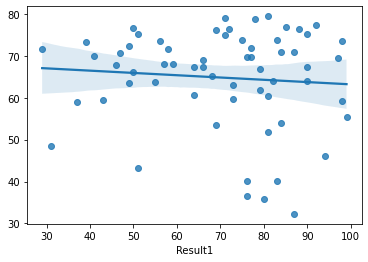

In [24]:
sns.regplot(y_test_Result1,test_pred)

In [54]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy